In [1]:
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import parseSessionID, session_dirs
from utils.plot_utils import shiftedColorMap, template_reorder
from open_ephys.analysis import Session##
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from spikeinterface.core.sorting_tools import random_spikes_selection
import pickle
import datetime
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
from tqdm import tqdm
import shutil

In [6]:
def load_and_preprocess_recording(session_folder, stream_name):
    ephys_path = os.path.dirname(session_folder)
    compressed_folder = os.path.join(ephys_path, 'ecephys_compressed')
    recording_zarr = [os.path.join(compressed_folder, f) for f in os.listdir(compressed_folder) if stream_name in f][0]
    recording = si.read_zarr(recording_zarr)
    # preprocess
    recording_processed = spre.phase_shift(recording)
    recording_processed = spre.highpass_filter(recording_processed)    
    recording_processed = spre.common_reference(recording_processed)
    return recording_processed

In [52]:
session = 'behavior_754897_2025-03-13_11-20-42'
data_type = 'curated'
target = 'soma'
session_dir = session_dirs(session)
# ROI session
session = 'behavior_754897_2025-03-13_11-20-42'
unit_id = 49
roi_site = 'surface_PrL'

filename = rf"{session}_unit_{unit_id}_{roi_site}"



In [74]:
# spike times
subject_id = session.split('_')[1]
session_id = '_'.join(session.split('_')[1:3])
print(session_id)

root_folder = '/root/capsule/data/LC-NE_scratch_data_06-14-2025'
spike_times_folder = rf'{root_folder}/{subject_id}/{session}/ephys/{data_type}/processed'
with open(os.path.join(spike_times_folder, 'spiketimes.pkl'), 'rb') as f:
    spiketimes = pickle.load(f)

unit_spike_times = spiketimes[unit_id]



754897_2025-03-13


'behavior_754897_2025-03-13_11-20-42_unit_49_surface_PrL'

In [12]:
event_csv = '/root/capsule/data/LC-NE_scratch_data_06-14-2025/754897/behavior_754897_2025-03-13_11-20-42/ephys/opto/curated/behavior_754897_2025-03-13_11-20-42_opto_session.csv'
event_ids = pd.read_csv(event_csv)
event_ids 


,Unnamed: 0,power,param_group,emission_location,duration,rise_time,num_pulses,pulse_interval,wavelength,type,interval,pre_post,freq,time,laser_onset_samples,site
0,0,50,train5Hz,surface_LC,4,1,5,196,red,external_red,1.05,pre,5,7.165634e+06,9388065,surface_LC
1,1,30,train5Hz,surface_LC,4,1,5,196,red,external_red,1.21,pre,5,7.165637e+06,9452282,surface_LC
2,2,50,train5Hz,surface_LC,4,1,5,196,red,external_red,1.20,pre,5,7.165639e+06,9521564,surface_LC
3,3,50,train5Hz,surface_LC,4,1,5,196,red,external_red,1.28,pre,5,7.165641e+06,9590668,surface_LC
4,4,30,train5Hz,surface_LC,4,1,5,196,red,external_red,1.13,pre,5,7.165644e+06,9662261,surface_LC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,435,50,train5Hz,surface_SC,5,1,5,195,red,external_red,1.19,post,5,7.171539e+06,186524760,surface_SC
436,436,50,train5Hz,surface_SC,5,1,5,195,red,external_red,1.36,post,5,7.171541e+06,186593686,surface_SC
437,437,50,train5Hz,surface_SC,5,1,5,195,red,external_red,1.37,post,5,7.171544e+06,186667683,surface_SC
438,438,50,train5Hz,surface_SC,5,1,5,195,red,external_red,1.26,post,5,7.171546e+06,186742073,surface_SC


In [53]:
roi_rows = event_ids.query("emission_location ==@roi_site")
# Stimulation parameters
roi_event_times = []

for i, row in roi_rows.iterrows():  # FIX 1: Use the correct method on the DataFrame
    roi_event_time = row.time    

    # FIX 2: Don't use np.unique() on scalars; just access the value directly
    duration = row.duration
    num_pulses = row.num_pulses
    pulse_interval = row.pulse_interval

    for pulse_num in range(num_pulses):
        time_shift = pulse_num * (duration + pulse_interval) / 1000  # convert ms to s
        this_event_time = roi_event_time + time_shift
        roi_event_times.append(this_event_time)  # FIX 3: use append, not extend


In [47]:
antidromic_stim_times = roi_event_times

In [8]:
# filter good channels
recording_processed = load_and_preprocess_recording(session_dir['session_dir'], 'ProbeA')
we = si.load(session_dir[f'postprocessed_dir_{data_type}'], load_extensions=False)
good_channel_ids = recording_processed.channel_ids[
            np.in1d(recording_processed.channel_ids, we.channel_ids)
        ]
recording_processed_good = recording_processed.select_channels(good_channel_ids)
print(f"Num good channels: {recording_processed_good.get_num_channels()}")

Num good channels: 384


/tmp/ipykernel_5898/3007250519.py:5: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  np.in1d(recording_processed.channel_ids, we.channel_ids)


In [27]:
extremum_channel_ids = si.get_template_extremum_channel(we)

In [9]:
# rec_times = recording_preprocessed.get_times()
rec_times = recording_processed_good.get_times()


In [10]:
rec_times[0]



np.float64(7165321.4512281455)

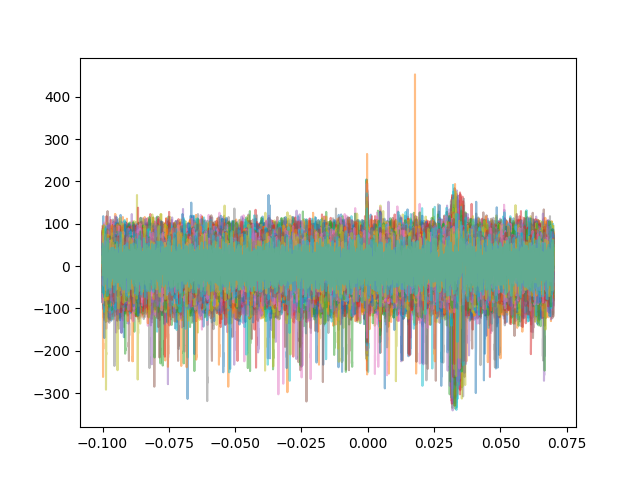

In [101]:
%matplotlib widget
import utils.analysis_funcs as af
import utils.plotting_funcs as pf


cutout_post = 0.07
trial_data = []  # list to store dicts for each trial

plt.figure()

for i, evt in enumerate(antidromic_stim_times):
    evt_index = np.searchsorted(rec_times, evt)
    start_frame = evt_index - int(cutout_pre * we.sampling_frequency)
    end_frame = evt_index + int(cutout_post * we.sampling_frequency)

    target_unit = unit_id
    best_channel = extremum_channel_ids[target_unit]

    trace = recording_processed.get_traces(
        start_frame=start_frame,
        end_frame=end_frame,
        channel_ids=[best_channel]
    )[:, 0]

    

    times_for_evt = rec_times[start_frame:end_frame]
    aligned_times = times_for_evt - evt  # x-values aligned to event

    # Plot
    plt.plot(aligned_times, trace, alpha=0.5)

    # spikes
    this_time_range = np.array([-cutout_pre, cutout_post])
    this_locked = af.event_locked_timestamps(
                    unit_spike_times, [evt], this_time_range, time_shift=0
                )
    int_event_locked_timestamps.extend(this_locked)

    # Save to trial_data
    trial_data.append({
        "trial": i,
        "x": aligned_times,
        "y": trace,
        "unit_spike_times": this_locked,
    })

# Convert to DataFrame
trial_df = pd.DataFrame(trial_data)


In [100]:
%matplotlib widget
cutout_pre = 0.1
cutout_post = 0.05
trial_data = []  # list to store dicts for each trial

# plt.figure()
import utils.analysis_funcs as af
import utils.plotting_funcs as pf

int_event_locked_timestamps = []
for i, evt in enumerate(antidromic_stim_times):
    this_time_range = np.array([-cutout_pre, cutout_post])
    this_locked = af.event_locked_timestamps(
                    unit_spike_times, [evt], this_time_range, time_shift=0
                )
    int_event_locked_timestamps.extend(this_locked)
    
    # # Plot
    # plt.plot(aligned_times, trace, alpha=0.5)

    # # Save to trial_data
    trial_data.iloc[i].append({
                "unit_spike_times": this_locked,
    })
# pf.raster_plot(int_event_locked_timestamps, time_range_raster, cond_each_trial=pulse_nums, ms=100, ax=ax_raster)

trial_data

AttributeError: 'list' object has no attribute 'iloc'

In [104]:
trial_df

,trial,x,y,unit_spike_times
0,0,"[-0.0999901620671153, -0.09995682910084724, -0...","[24, 23, 14, 1, 29, 19, 17, -24, -47, -21, -53...",[[0.03201121650636196]]
1,1,"[-0.09998807311058044, -0.09995473921298981, -...","[-39, -7, -11, 33, 12, 60, -10, 22, 33, 59, 49...",[[0.031579967588186264]]
2,2,"[-0.09998598415404558, -0.09995265025645494, -...","[3, 29, -19, -35, 19, 14, 6, 14, 50, 1, 26, -4...",[[0.030915383249521255]]
3,3,"[-0.09998389426618814, -0.09995056036859751, -...","[-13, -49, 9, -13, -27, -12, -43, -4, -12, 5, ...",[[0.03158531058579683]]
4,4,"[-0.09997978992760181, -0.09994645603001118, -...","[-17, -1, 21, -6, 11, 15, 20, 44, 52, 55, 31, ...","[[-0.0376783637329936, 0.030989875085651875]]"
...,...,...,...,...
495,495,"[-0.09997117146849632, -0.09993783757090569, -...","[8, 47, 21, 10, 11, 45, -22, 32, 38, -28, 29, ...",[[]]
496,496,"[-0.09999994095414877, -0.09996660705655813, -...","[0, 23, 13, 72, 28, 68, 33, -3, 2, -7, 22, -46...",[[]]
497,497,"[-0.099995375610888, -0.09996204171329737, -0....","[-8, 16, 31, 51, 23, 24, 4, 49, 7, -19, 3, 30,...",[[0.0479746675118804]]
498,498,"[-0.09999081026762724, -0.0999574763700366, -0...","[-21, 25, 4, 42, -7, 14, 20, 43, 59, 86, 87, 5...",[[0.03470930643379688]]


In [106]:
result_folder = '/root/capsule/results'
filename = rf"{session}_unit_{unit_id}_{roi_site}_trace_spike.pkl"
antidromic_trace_file = os.path.join(result_folder, filename)
trial_df.to_pickle(antidromic_trace_file)
trial_df

,trial,x,y,unit_spike_times
0,0,"[-0.0999901620671153, -0.09995682910084724, -0...","[24, 23, 14, 1, 29, 19, 17, -24, -47, -21, -53...",[[0.03201121650636196]]
1,1,"[-0.09998807311058044, -0.09995473921298981, -...","[-39, -7, -11, 33, 12, 60, -10, 22, 33, 59, 49...",[[0.031579967588186264]]
2,2,"[-0.09998598415404558, -0.09995265025645494, -...","[3, 29, -19, -35, 19, 14, 6, 14, 50, 1, 26, -4...",[[0.030915383249521255]]
3,3,"[-0.09998389426618814, -0.09995056036859751, -...","[-13, -49, 9, -13, -27, -12, -43, -4, -12, 5, ...",[[0.03158531058579683]]
4,4,"[-0.09997978992760181, -0.09994645603001118, -...","[-17, -1, 21, -6, 11, 15, 20, 44, 52, 55, 31, ...","[[-0.0376783637329936, 0.030989875085651875]]"
...,...,...,...,...
495,495,"[-0.09997117146849632, -0.09993783757090569, -...","[8, 47, 21, 10, 11, 45, -22, 32, 38, -28, 29, ...",[[]]
496,496,"[-0.09999994095414877, -0.09996660705655813, -...","[0, 23, 13, 72, 28, 68, 33, -3, 2, -7, 22, -46...",[[]]
497,497,"[-0.099995375610888, -0.09996204171329737, -0....","[-8, 16, 31, 51, 23, 24, 4, 49, 7, -19, 3, 30,...",[[0.0479746675118804]]
498,498,"[-0.09999081026762724, -0.0999574763700366, -0...","[-21, 25, 4, 42, -7, 14, 20, 43, 59, 86, 87, 5...",[[0.03470930643379688]]


754897_2025-03-13


array([7165322.10952748, 7165322.50142709, 7165323.19052508, ...,
       7171567.13915701, 7171567.35215679, 7171567.52092329])